In [1]:
%matplotlib inline
from rdkit import Chem
from rdkit.Chem import AllChem
import nglview
import csv
import numpy as np
import matplotlib.pyplot as plt

### As a starting point, you have been given a list of molecules in SMILES format containing compounds taken from the WHO (World Health Organization) Essential Medicine List. 

Many, but not all of the essential medicines are small molecules. Roughly speaking, a small molecule is a molecule of relatively low molecular weight - a commonly cited value is < 900 daltons - in order to distinguish them from larger molecules such as proteins and polymers.

`WHO_EML_SMILES.csv` is a text file, where on each line there are two values separated by a comma. The first value is the name of the drug and the second value contains the 2D molecular structure in SMILES format. These SMILES strings were generated as part of a [research paper](https://doi.org/10.1039/C9RE00348G) and kindly provided by the authors, Klavs Jensen and Hanyu Gao.

We will begin by using the `csv` module to read in the file. As we can see here, the csv.reader function returns an iterable object containing the contents of the file.

In [2]:
with open('WHO_EML_SMILES.csv') as csv_file:
    reader = csv.reader(csv_file)
    for line in reader:
        print(line)

['abacavir', 'Nc1nc(NC2CC2)c3ncn([C@@H]4C[C@H](CO)C=C4)c3n1']
['acetazolamide', 'CC(=O)Nc1sc(nn1)[S](N)(=O)=O']
['acetic acid', 'CC(O)=O']
['acetylcysteine', 'CC(=O)N[C@@H](CS)C(O)=O']
['acetylsalicylic acid', 'CC(=O)Oc1ccccc1C(O)=O']
['aciclovir', 'NC1=NC(=O)c2ncn(COCCO)c2N1']
['albendazole', 'CCCSc1ccc2nc(NC(=O)OC)[nH]c2c1']
['allopurinol', 'O=C1N=CN=C2NNC=C12']
['aluminium diacetate', '[Al++].CC([O-])=O.CC([O-])=O']
['aluminium hydroxide', '[OH-].[OH-].[OH-].[Al+3]']
['amidotrizoate', 'CC(=O)Nc1c(I)c(NC(C)=O)c(I)c(C(O)=O)c1I']
['amikacin', 'NCC[C@H](O)C(=O)N[C@@H]1C[C@H](N)[C@@H](O[C@H]2O[C@H](CN)[C@@H](O)[C@H](O)[C@H]2O)[C@H](O)[C@H]1O[C@H]3O[C@H](CO)[C@@H](O)[C@H](N)[C@H]3O']
['amiloride', 'NC(N)=NC(=O)c1nc(Cl)c(N)nc1N']
['aminophylline', 'CN1C(=O)N(C)c2nc[nH]c2C1=O.CN3C(=O)N(C)c4nc[nH]c4C3=O.NCCN']
['amiodarone', 'CCCCc1oc2ccccc2c1C(=O)c3cc(I)c(OCCN(CC)CC)c(I)c3']
['amitriptyline', 'CN(C)CCC=C1c2ccccc2CCc3ccccc13']
['amlodipine', 'CCOC(=O)C1=C(COCCN)NC(=C(C1c2ccccc2Cl)C(=O)OC)C']

Take abacavir for example, the first line in the file. This is a medication used to treat HIV/AIDS. To start working with this molecule, we could build the structure in Avogadro, but a more systematic way would be to create a molecule object directly from the SMILES string.  The RDKit toolkit allows us to do this.

In [3]:
# Generate an RDKit molecule object from a SMILES string.
# The example uses abacavir taken from the above printout.
m1 = Chem.MolFromSmiles('Nc1nc(NC2CC2)c3ncn([C@@H]4C[C@H](CO)C=C4)c3n1')

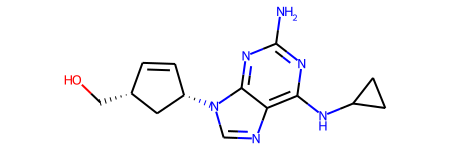

In [4]:
# This is how the RDKit molecule object is represented - as a 2D drawing.
m1

In [5]:
# Starting from SMILES, there are no 3-D coordinates and they need to be generated.
# This is how RDKit generates 3-D conformers for a molecule.
# Under the hood, it uses a method called ETDKG to do this.
AllChem.EmbedMolecule(m1)

RDKit WARNING: [13:57:59] Molecule does not have explicit Hs. Consider calling AddHs()


0

In [6]:
# Now we can print out the 3D coordinates. Note that hydrogen atoms are missing.
print(Chem.MolToXYZBlock(m1))

21

N      0.334415    2.256787    1.997453
C      0.597814    1.269498    1.026155
N      1.881035    1.096082    0.634450
C      2.264695    0.188415   -0.283800
N      3.610711    0.018385   -0.683571
C      4.625571    0.849885   -0.086580
C      4.851607    0.821314    1.399328
C      5.885584    0.306313    0.441183
C      1.258408   -0.581960   -0.825081
N      1.260820   -1.558889   -1.740021
C     -0.022996   -1.995598   -1.919351
N     -0.792622   -1.288158   -1.119546
C     -2.291256   -1.540994   -1.088350
C     -2.792726   -0.034890   -0.808529
C     -4.235149   -0.666128   -0.256521
C     -4.509729    0.663422    0.665907
O     -5.678789    0.522312    1.322173
C     -3.440055   -1.484943    0.897090
C     -2.384844   -1.947035    0.419162
C     -0.057689   -0.439675   -0.456642
N     -0.364804    0.486329    0.465091



In [7]:
# nglview has a nice tool for allowing us to view the 3D coordinates as well.
nglview.show_rdkit(m1)

NGLWidget()

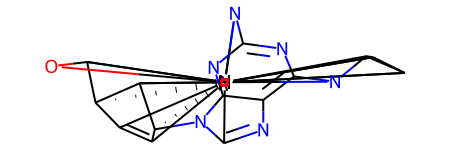

In [8]:
# Note that the structure has no hydrogens. This will interfere with quantum calcs
# and possibly even with conformer generation (though it didn't this time).
# Hydrogens need to be added explicitly to a structure in RDKit.
m1h = Chem.AddHs(m1)
m1h

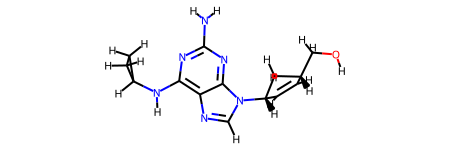

In [9]:
# The 2D structure doesn't make sense but that's because we need to re-run the conformer generation
# to place the hydrogen atoms in the right places. In the future, you could run the "Chem.AddHs()"
# immediately after creating the molecule from SMILES.
AllChem.EmbedMolecule(m1h)
m1h

In [10]:
# Ah, much better
print(Chem.MolToXYZBlock(m1h))
nglview.show_rdkit(m1h)

39

N     -1.138271    2.980919    0.297381
C     -1.186806    1.540524    0.207489
N     -2.390155    0.946733    0.164249
C     -2.564764   -0.382049    0.080630
N     -3.815632   -1.041326    0.038150
C     -5.103837   -0.404570    0.066153
C     -5.476373    0.481388    1.196096
C     -5.331744    1.012545   -0.209477
C     -1.408089   -1.132809    0.039940
N     -1.171097   -2.447487   -0.040688
C      0.158760   -2.649520   -0.046340
N      0.812377   -1.475862    0.030147
C      2.235794   -1.355647    0.045052
C      2.732880   -0.107716    0.742153
C      4.193054   -0.145734    0.274109
C      4.846013    1.195396    0.394512
O      6.148652    1.087805   -0.040927
C      3.993764   -0.550629   -1.154746
C      2.865027   -1.245120   -1.270796
C     -0.151270   -0.538804    0.083476
N     -0.060157    0.807441    0.167745
H     -1.771819    3.513443    0.934387
H     -0.468481    3.528253   -0.272115
H     -3.769219   -2.110804   -0.019222
H     -5.943290   -1.085398   -0.257

NGLWidget()

The power of cheminformatic tools becomes apparent when you want to work with big batches of molecules. For example we can create RDKit molecule objects from each molecule in the file:

In [11]:
WHO_Molecules = {}
with open('WHO_EML_SMILES.csv') as csv_file:
    reader = csv.reader(csv_file)
    for line in reader:
        key = line[0]
        smi = line[1]
        WHO_Molecules[key] = Chem.MolFromSmiles(smi)

RDKit WARNING: [13:57:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:59] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [13:57:59] WARNING: not removing hydrogen atom without neighbors


Running the above command produced a few warnings for me, which is to be expected when working with large datasets, but there were no errors.

Now that we have a list of Molecule objects, we could calculate some properties.  For example, let's calculate the molecular weight of all the compounds and make a histogram.  The correct API call to use can be obtained by Google searching "rdkit molecular weight". It gives us a function `rdkit.Chem.Descriptors.ExactMolWt` which takes a molecule object as input.

(array([290.,  32.,   9.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([  18.01056468,  596.57327312, 1175.13598155, 1753.69868998,
        2332.26139841, 2910.82410684, 3489.38681527, 4067.9495237 ,
        4646.51223213, 5225.07494056, 5803.637649  ]),
 <BarContainer object of 10 artists>)

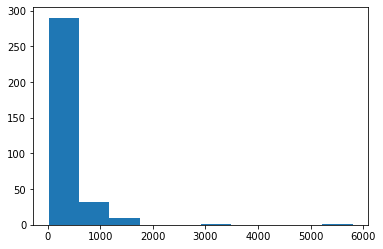

In [12]:
# For reasons unknown, we had to important ExactMolWt explicitly.
from rdkit.Chem.Descriptors import ExactMolWt
MolWts = []
for molname, molobj in WHO_Molecules.items():
    MolWts.append(ExactMolWt(molobj))
plt.hist(MolWts)

The above histogram was somewhat useful but we didn't get much info on the distribution of molecular weights other than that they are mostly under 1000.  Apparently the list also contains just a few molecules with even larger weights.  How about we plot a histogram with just the weights under 1000?

(array([18., 58., 78., 68., 46., 16., 14.,  5.,  9.,  7.]),
 array([ 18.01056468, 109.06025107, 200.10993746, 291.15962385,
        382.20931024, 473.25899663, 564.30868302, 655.35836941,
        746.4080558 , 837.45774219, 928.50742858]),
 <BarContainer object of 10 artists>)

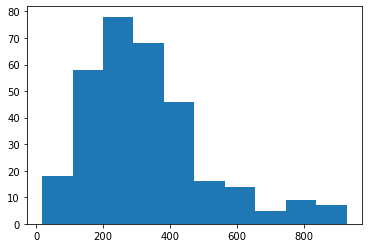

In [13]:
MolWts = np.array(MolWts)
plt.hist(MolWts[np.where(MolWts<1000)])

Great, that's a bit more informative.  We could also count the number of carbon atoms in each molecule and see if it's correlated with the molecular weight. After a bit of experimentation I figured out how to get the atomic symbols for an example molecule:

In [14]:
mol_a = WHO_Molecules['abacavir']
for atom in mol_a.GetAtoms():
    print(atom.GetSymbol())

N
C
N
C
N
C
C
C
C
N
C
N
C
C
C
C
O
C
C
C
N


(-2.0, 50.0)

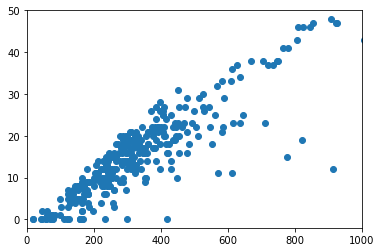

In [15]:
# In Python 3.6 onwards (we are using 3.7 I think), dictionary keys are ordered.
# In past versions and possibly other Python implementations, the keys may not be ordered.
# Therefore, it is a good idea to make a sorted list of keys before making element-wise
# comparisons between properties.
NumCarbons = []
MolWts = []
MolNames = sorted(list(WHO_Molecules.keys()))
for molname in MolNames:
    molobj = WHO_Molecules[molname]
    MolWts.append(ExactMolWt(molobj))
    num_C = 0
    for atom in molobj.GetAtoms():
        if atom.GetSymbol() == 'C':
            num_C += 1
    NumCarbons.append(num_C)
plt.scatter(MolWts, NumCarbons)
# I set the plot limits to focus on the MW < 1000 molecules.
plt.xlim(0, 1000)
plt.ylim(-2, 50)

### So far, we have only worked on the SMILES strings. Now let's see how we can incorporate some experimental data. 

There are lots of kinds of experimental data, and here we will show how to get some crystal structures into the notebook.  This will require doing some work outside of the notebook as well.

First, pick a SMILES string of interest. We will look at clomipramine, whose SMILES string is CN(C)CCCN1c2ccccc2CCc3ccc(Cl)cc13 .  You can get the SMILES strings from the .csv file either by opening it directly as a spreadsheet in Excel or other software, or by printing the keys of the `WHO_Molecules` dictionary from above.

Connect to "CCDC Access Structures" at the link: https://www.ccdc.cam.ac.uk/structures/ .  Make sure you are on campus or using the [library VPN](https://www.library.ucdavis.edu/service/connect-from-off-campus/), otherwise you will hit a paywall at the next step.  

![Structure search](https://i.imgur.com/dkbIz0t.png)

Click on the "Structure Search" tab.  Click the "Advanced ↓" button at the lower left.  Click the "Substructure" radio button next to "Match condition:", and paste the SMILES string for your molecule into the box that says SMARTS.  (SMARTS is a language for searching for molecular structures, and generally a SMILES string is a valid SMARTS string).  You might get an error for SMILES strings that contain "@" characters that specify stereochemistry.  In these cases, remove the "@" signs from your string using a text editor, or a command line tool such as sed.

![Search results](https://i.imgur.com/q1k4J2Z.png)

After the search, you should see several results pop up.  Crystal structues often contain more than just the molecule of interest.  For example, the first entry that popped up in my search, which had the identifier BUXKIR, had the molecule of interest inside of a cyclodextrin ring.  Some molecules may be similar but not identical to the molecule you're searching for.  Look for a structure where the details include the name of the drug.  For example, CIMPRA lists "Chlorimipramine hydrochloride" under Synonyms, and a quick Wikipedia search shows that Chlorimipramine and clomipramine are synonymous.  That should be close enough for us.  Download the CIF file to your hard drive by clicking Download -> Download Current Entry.  Move the CIF file to the same folder where you have your notebook. 

Before you can load a structure into RDKit, another cheminformatic tool called OpenBabel is needed to convert the .cif file into a file format that RDKit can read (here we will use .mol2).  In the folder where you have your notebook and the .mol2 file, run OpenBabel in your terminal (not in the notebook!) as follows:

```
(che155) $ obabel -icif 1125716.cif -omol2 -O 1125716.mol2
1 molecule converted
```

Now you should be able to load the .mol2 file into your notebook.  The default behavior is to remove hydrogen atoms from the structure, so we pass in the keyword argument to keep hydrogens ([see RDKit documentation](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html#rdkit.Chem.rdmolfiles.MolFromMol2File).)

In [16]:
mol_exp = Chem.MolFromMol2File('1125716.mol2', removeHs=False)

We can also use NGLView to show the 3D structure of the molecule here:

In [17]:
nglview.show_rdkit(mol_exp)

NGLWidget()

An interesting question to ask is, how well does the computationally generated conformation agree with the experimental one?  This touches on the cutting-edge field of crystal structure prediction, which is very important to industry as well as basic science.

To look at this, we can create another RDKit molecule object directly from the SMILES string with no additional experimental data, generate a number of conformers, and compare the results to the above.  The API call `AllChem.EmbedMultipleConfs` is how we ask RDKit to generate multiple conformers for a molecule ([see RDKit documentation](https://www.rdkit.org/docs/source/rdkit.Chem.rdDistGeom.html#rdkit.Chem.rdDistGeom.EmbedMultipleConfs).)

In [18]:
mol_smi = Chem.MolFromSmiles('CN(C)CCCN1c2ccccc2CCc3ccc(Cl)cc13')
mol_smi_h = AllChem.AddHs(mol_smi)
# The random seed argument is added so that multiple runs will give the same result.
AllChem.EmbedMultipleConfs(mol_smi_h, 10, randomSeed=8282)

Using NGLView we can visualize each 3D conformation.  The keyword argument for controlling which conformer to show is `conf_id` (I figured this out using `help(nglview.show_rdkit)`).  I don't know whether it's possible change the conformer being viewed with a slider.

In [19]:
nglview.show_rdkit(mol_smi_h, conf_id=3)

NGLWidget()

A powerful feature of RDKit is the ability to perform structure alignment.  This is a calculation in which the structures of two conformations are compared by applying a translation and rotation to one confomation, called the probe, in order to minimize the distances to a reference conformation.  After applying the rotation and translation, the remaining Euclidean distances between the atoms of the probe and reference structure are a measure of the "internal" structural differences due to differences in bond lengths, etc.  By taking the RMS of all the displacements for each atom, one can calculate the "RMSD" which is a single number that measures the difference between two structures.

In order to rotate two structures to minimize the distances between corresponding atoms, both structures need to have the same atom ordering, which is actually not true for our experimental structure and the generated one.  What's more, the atoms of the probe and reference structure need to be the same, and this is not strictly true for our example either, because our experimental structure is actually a hydrochloride salt, containing an extra HCl that the generated structure doesn't have.  RDKit takes care of both of these problems by finding a substructure that the probe and reference structures have in common; the substructure matching also generates a mapping of the atom orderings between one structure and the other, so we are able to get a result without worryinng.

In [20]:
for i in range(mol_smi_h.GetNumConformers()):
    print(Chem.rdMolAlign.AlignMol(mol_smi_h, mol_exp, i))

1.602497851031555
2.632707324279703
2.84139227272008
2.329167114727071
3.0261916639798536
3.0747435908293967
1.412858791842668
2.675587894652636
2.2960884334467804
3.0856092863330726


The interpretation of RMSD depends on the situation, but here we use a very rough rule of thumb that a RMSD value of 1 Angstrom or less indicates a high level of agreement for molecular structures.  Above we see that conformer number 6 has the best level of agreement with experiment.  Let's plot them together to look at how close the structures are.

I'd prefer showing the generated conformer in a different color from the experiment, but I don't know how to get NGLView's API to do that.  Bonus points to anyone who manages to figure it out!

In [22]:
view = nglview.show_rdkit(mol_smi_h, conf_id=6)
view.add_component(mol_exp)
view

NGLWidget()